In [1]:
#Load csv file
import pandas as pd
import csv
import os, math, random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

os.chdir('C:/Negar/DSM_Sweden')  # Change to your working directory
file_path = 'output/national_soildata_with_time_covariates2.csv'
soildata_covariates = pd.read_csv(file_path)

In [2]:
# Define the exact covariate names you want in X
covariate_names = [
    "dfme_edtm", "geomorphon_edtm", "hillshade_edtm", "ls.factor_edtm", 
    "maxic_edtm", "minic_edtm", "neg.openness_edtm", "pos.openness_edtm", 
    "pro.curv_edtm", "shpindx_edtm", "slope.in.degree_edtm", "twi_edtm",
    "BSF_Yearly", "NDVI_Yearly", "NIR_Yearly", "NDWI_Yearly", "NDTI_Yearly",
    "Red_Yearly", "SWIR2_Yearly", "SWIR1_Yearly", "Green_Yearly", "Blue_Yearly",
    "CHELSA_Monthly_Precip", "ERA5_Monthly_Temp", "EVI_Bimonthly", 
    "NDSI_Bimonthly", "SAVI_Bimonthly", "bergart_rock_type","litotektonisk_enhet",
    #"crop_type","CDR_Yearly"
]

# Filter the DataFrame
X = soildata_covariates[covariate_names]

# Define Y
Y = soildata_covariates["Org mtrl (% ts)"]

# Convert Y to numeric, handling commas and stripping whitespace
Y = (
    Y.astype(str)
    .str.strip()
    .str.replace(',', '.')
)
Y = pd.to_numeric(Y, errors='coerce')
print(Y.dtype)


float64


In [3]:
data = pd.concat([X, Y], axis=1).dropna()
X_clean = data[covariate_names].values.astype(np.float32)
Y_clean = data["Org mtrl (% ts)"].values.astype(np.float32).reshape(-1, 1)


# Check again
print("Shape of X_clean:", X_clean.shape)
print("Shape of Y_clean:", Y_clean.shape)


Shape of X_clean: (12595, 29)
Shape of Y_clean: (12595, 1)


## Neural Network with Loss function



In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_clean, Y_clean, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# ======================== 4. دیتاست و دیتالودر =======================
class SoilDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SoilDataset(X_train, Y_train)
test_ds  = SoilDataset(X_test , Y_test )

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds , batch_size=256, shuffle=False)

# =========================== 5. مدل MLP ==============================
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 128), nn.ReLU(),
            nn.Linear(128, 64 ), nn.ReLU(),
            nn.Linear(64 , 32 ), nn.ReLU(),
            nn.Linear(32 , 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(n_in=X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ====================== 6. تابع زیان سفارشی ===========================
class SoilInformedLoss(nn.Module):
    def __init__(self, λ_neg=10, λ_hi=5, λ_ndvi=1, λ_temp=1,
                 hi_threshold=20.0):
        super().__init__()
        self.mse = nn.MSELoss()
        self.λ_neg, self.λ_hi = λ_neg, λ_hi
        self.λ_ndvi, self.λ_temp = λ_ndvi, λ_temp
        self.hi_threshold = hi_threshold
        # اندیس ستون‌های NDVI و Temp برای دسترسی سریع:
        self.idx_ndvi = covariate_names.index("NDVI_Yearly")
        self.idx_temp = covariate_names.index("ERA5_Monthly_Temp")

    def forward(self, y_pred, y_true, X_batch, mask_organic):
        loss = self.mse(y_pred, y_true)

        # Penalty 1: OC منفی
        loss += self.λ_neg * torch.relu(-y_pred).mean()

        # Penalty 2: OC خیلی بالا (>20%) فقط روی خاک غیرارگانیک
        hi_excess = torch.relu(y_pred - self.hi_threshold)
        loss += self.λ_hi * (hi_excess * (~mask_organic)).mean()

        # Penalty 3: اگر همبستگی NDVI و OC منفی شود
        ndvi = X_batch[:, self.idx_ndvi]
        if ndvi.std() > 0:
            corr_ndvi = torch.cov(torch.vstack([y_pred.squeeze(), ndvi]))[0,1] / (
                        y_pred.std() * ndvi.std() + 1e-6)
            loss += self.λ_ndvi * torch.relu(-corr_ndvi)

        # Penalty 4: اگر همبستگی دما و OC مثبت شود
        temp = X_batch[:, self.idx_temp]
        if temp.std() > 0:
            corr_temp = torch.cov(torch.vstack([y_pred.squeeze(), temp]))[0,1] / (
                        y_pred.std() * temp.std() + 1e-6)
            loss += self.λ_temp * torch.relu(corr_temp)

        return loss

criterion = SoilInformedLoss()

# ========================== 7. آموزش ================================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 50

def ccc(a, b):
    mean_a, mean_b = a.mean(), b.mean()
    cov = ((a-mean_a)*(b-mean_b)).mean()
    var_a, var_b = a.var(), b.var()
    return (2*cov) / (var_a + var_b + (mean_a-mean_b)**2 + 1e-6)

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        mask_org = (xb[:, covariate_names.index("bergart_rock_type")] == 5)  # مثال: کلاس 5 = خاک ارگانیک
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb, xb, mask_org)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    # ---------- ارزیابی رو دیتای تست ----------
    model.eval(); preds_list, y_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu()
            preds_list.append(preds)
            y_list.append(yb)
    y_pred = torch.cat(preds_list).squeeze()
    y_true = torch.cat(y_list).squeeze()
    r2   = 1 - ((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum()
    rmse = torch.sqrt(((y_true - y_pred)**2).mean())
    ccc_val = ccc(y_true, y_pred)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}: Loss={train_loss/len(train_ds):.3f} | "
              f"R²={r2:.3f} | RMSE={rmse:.2f} | CCC={ccc_val:.3f}")

# ====================== 8. ذخیره مدل و اسکیلر =======================
torch.save(model.state_dict(), "soil_mlp_informed.pt")
import joblib
joblib.dump(scaler, "soil_scaler.pkl")

Epoch 01: Loss=104.751 | R²=0.034 | RMSE=9.15 | CCC=0.146
Epoch 05: Loss=64.830 | R²=0.215 | RMSE=8.24 | CCC=0.327
Epoch 10: Loss=56.718 | R²=0.324 | RMSE=7.65 | CCC=0.471
Epoch 15: Loss=52.457 | R²=0.371 | RMSE=7.38 | CCC=0.527
Epoch 20: Loss=49.733 | R²=0.378 | RMSE=7.34 | CCC=0.538
Epoch 25: Loss=47.289 | R²=0.387 | RMSE=7.29 | CCC=0.530
Epoch 30: Loss=44.943 | R²=0.394 | RMSE=7.24 | CCC=0.545
Epoch 35: Loss=42.259 | R²=0.384 | RMSE=7.30 | CCC=0.539
Epoch 40: Loss=40.376 | R²=0.392 | RMSE=7.25 | CCC=0.553
Epoch 45: Loss=38.283 | R²=0.393 | RMSE=7.25 | CCC=0.575
Epoch 50: Loss=35.346 | R²=0.384 | RMSE=7.31 | CCC=0.574


['soil_scaler.pkl']

Quick Monitoring 

اگر اعداد تخطّی نزدیک صفر باشند، پنالتی‌ها کار خود را می‌کنند.



In [18]:
def check_violations(preds, X):
    neg = (preds < 0).sum().item()
    hi  = (preds > 20).sum().item()
    ndvi = X[:, criterion.idx_ndvi]
    temp = X[:, criterion.idx_temp]
    corr_ndvi = np.corrcoef(preds.squeeze(), ndvi)[0,1]
    corr_temp = np.corrcoef(preds.squeeze(), temp)[0,1]
    return neg, hi, corr_ndvi, corr_temp

model.eval()
with torch.no_grad():
    X_full = torch.tensor(X_test, device=device)
    y_pred = model(X_full).cpu().numpy()
neg, hi, c_ndvi, c_temp = check_violations(y_pred, X_test)
print(f"Negatives: {neg},  >20%: {hi},  corr(OC,NDVI)={c_ndvi:.2f},  corr(OC,Temp)={c_temp:.2f}")


Negatives: 0,  >20%: 76,  corr(OC,NDVI)=0.33,  corr(OC,Temp)=-0.08


In [10]:
# نشان‌دادن نمونه رکوردهای OC حقیقی بالا
df_high = data[ data["Org mtrl (% ts)"] > 20 ]
print(df_high["bergart_rock_type"].value_counts().head(10))
print(df_high["litotektonisk_enhet"].value_counts().head(10))


bergart_rock_type
203    144
204     65
303     55
427     47
205     43
103     30
411     30
314     29
313     22
206     21
Name: count, dtype: int64
litotektonisk_enhet
337    319
394    127
389     90
387     22
388     20
390     13
368      9
346      2
Name: count, dtype: int64


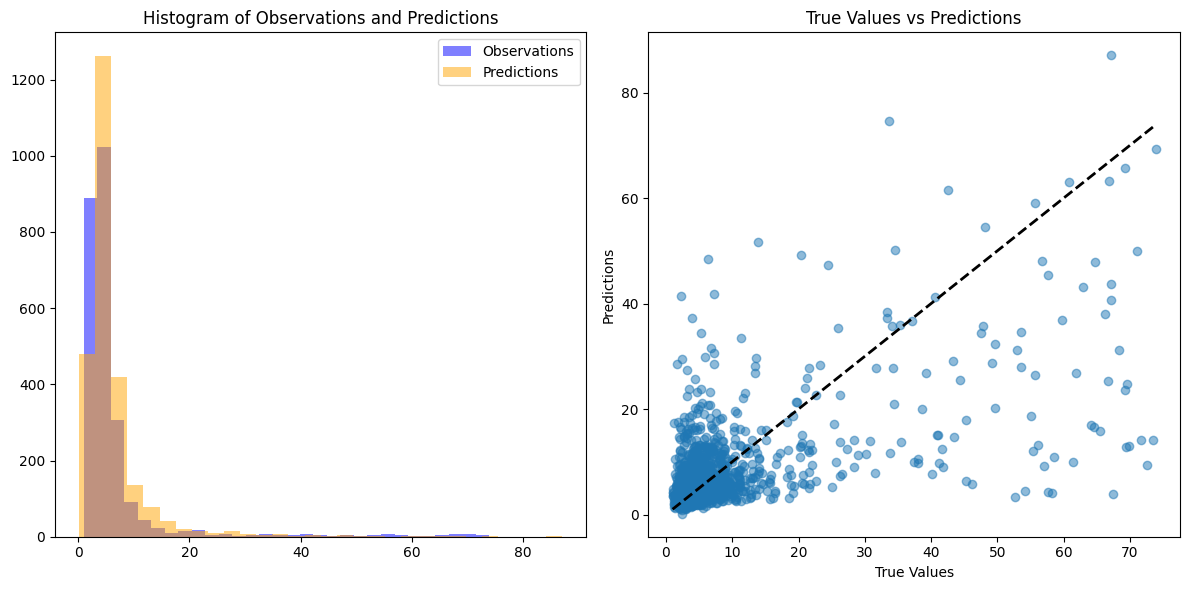

In [6]:
# check the histogram distribution of observations and predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(Y_test, bins=30, alpha=0.5, label='Observations', color='blue')
plt.hist(y_pred, bins=30, alpha=0.5, label='Predictions', color='orange')
plt.title('Histogram of Observations and Predictions')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.tight_layout()
plt.show()